<a href="https://colab.research.google.com/github/HiteshMalla1343/StyleGAN2/blob/main/StyleGAN2_Synthetic_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2, sqrt
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET                 = "/content/drive/MyDrive/sat"
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS                  = 300
LEARNING_RATE           = 1e-3
BATCH_SIZE              = 32
LOG_RESOLUTION          = 7 #for 128*128
Z_DIM                   = 256
W_DIM                   = 256
LAMBDA_GP               = 10

In [ ]:
def get_loader():
    transform = transforms.Compose(
        [
            transforms.Resize((2 ** LOG_RESOLUTION, 2 ** LOG_RESOLUTION)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5, 0.5, 0.5],
                [0.5, 0.5, 0.5],
            ),
        ]
    )
    dataset = datasets.ImageFolder(root=DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    return loader

In [ ]:
class EqualizedWeight(nn.Module):

    def __init__(self, shape):

        super().__init__()

        self.c = 1 / sqrt(np.prod(shape[1:]))
        self.weight = nn.Parameter(torch.randn(shape))

    def forward(self):
        return self.weight * self.c

In [ ]:
class EqualizedLinear(nn.Module):

    def __init__(self, in_features, out_features, bias = 0.):

        super().__init__()
        self.weight = EqualizedWeight([out_features, in_features])
        self.bias = nn.Parameter(torch.ones(out_features) * bias)

    def forward(self, x: torch.Tensor):
        return F.linear(x, self.weight(), bias=self.bias)

In [ ]:
class EqualizedConv2d(nn.Module):

    def __init__(self, in_features, out_features,
                 kernel_size, padding = 0):

        super().__init__()
        self.padding = padding
        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        self.bias = nn.Parameter(torch.ones(out_features))

    def forward(self, x: torch.Tensor):
        return F.conv2d(x, self.weight(), bias=self.bias, padding=self.padding)

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim)
        )

    def forward(self, x):
        x = x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)  # for PixelNorm
        return self.mapping(x)

In [ ]:
class Conv2dWeightModulate(nn.Module):

    def __init__(self, in_features, out_features, kernel_size,
                 demodulate = True, eps = 1e-8):

        super().__init__()
        self.out_features = out_features
        self.demodulate = demodulate
        self.padding = (kernel_size - 1) // 2

        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        self.eps = eps

    def forward(self, x, s):

        b, _, h, w = x.shape

        s = s[:, None, :, None, None]
        weights = self.weight()[None, :, :, :, :]
        weights = weights * s

        if self.demodulate:
            sigma_inv = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)
            weights = weights * sigma_inv

        x = x.reshape(1, -1, h, w)

        _, _, *ws = weights.shape
        weights = weights.reshape(b * self.out_features, *ws)

        x = F.conv2d(x, weights, padding=self.padding, groups=b)

        return x.reshape(-1, self.out_features, h, w)


In [ ]:
class ToRGB(nn.Module):

    def __init__(self, W_DIM, features):

        super().__init__()
        self.to_style = EqualizedLinear(W_DIM, features, bias=1.0)

        self.conv = Conv2dWeightModulate(features, 3, kernel_size=1, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(3))
        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x, w):

        style = self.to_style(w)
        x = self.conv(x, style)
        return self.activation(x + self.bias[None, :, None, None])

In [ ]:
class StyleBlock(nn.Module):

    def __init__(self, W_DIM, in_features, out_features):

        super().__init__()

        self.to_style = EqualizedLinear(W_DIM, in_features, bias=1.0)
        self.conv = Conv2dWeightModulate(in_features, out_features, kernel_size=3)
        self.scale_noise = nn.Parameter(torch.zeros(1))
        self.bias = nn.Parameter(torch.zeros(out_features))

        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x, w, noise):

        s = self.to_style(w)
        x = self.conv(x, s)
        if noise is not None:
            x = x + self.scale_noise[None, :, None, None] * noise
        return self.activation(x + self.bias[None, :, None, None])

In [ ]:
class GeneratorBlock(nn.Module):

    def __init__(self, W_DIM, in_features, out_features):

        super().__init__()

        self.style_block1 = StyleBlock(W_DIM, in_features, out_features)
        self.style_block2 = StyleBlock(W_DIM, out_features, out_features)

        self.to_rgb = ToRGB(W_DIM, out_features)

    def forward(self, x, w, noise):

        x = self.style_block1(x, w, noise[0])
        x = self.style_block2(x, w, noise[1])

        rgb = self.to_rgb(x, w)

        return x, rgb


In [ ]:
class Generator(nn.Module):

    def __init__(self, log_resolution, W_DIM, n_features = 32, max_features = 256):

        super().__init__()

        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 2, -1, -1)]
        self.n_blocks = len(features)

        self.initial_constant = nn.Parameter(torch.randn((1, features[0], 4, 4)))

        self.style_block = StyleBlock(W_DIM, features[0], features[0])
        self.to_rgb = ToRGB(W_DIM, features[0])

        blocks = [GeneratorBlock(W_DIM, features[i - 1], features[i]) for i in range(1, self.n_blocks)]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, w, input_noise):

        batch_size = w.shape[1]

        x = self.initial_constant.expand(batch_size, -1, -1, -1)
        x = self.style_block(x, w[0], input_noise[0][1])
        rgb = self.to_rgb(x, w[0])

        for i in range(1, self.n_blocks):
            x = F.interpolate(x, scale_factor=2, mode="bilinear")
            x, rgb_new = self.blocks[i - 1](x, w[i], input_noise[i])
            rgb = F.interpolate(rgb, scale_factor=2, mode="bilinear") + rgb_new

        return torch.tanh(rgb)

In [ ]:
class DiscriminatorBlock(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()
        self.residual = nn.Sequential(nn.AvgPool2d(kernel_size=2, stride=2), # down sampling using avg pool
                                      EqualizedConv2d(in_features, out_features, kernel_size=1))

        self.block = nn.Sequential(
            EqualizedConv2d(in_features, in_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True),
            EqualizedConv2d(in_features, out_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True),
        )

        self.down_sample = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        self.scale = 1 / sqrt(2)

    def forward(self, x):
        residual = self.residual(x)

        x = self.block(x)
        x = self.down_sample(x)

        return (x + residual) * self.scale

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, log_resolution, n_features = 64, max_features = 256):

        super().__init__()

        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 1)]

        self.from_rgb = nn.Sequential(
            EqualizedConv2d(3, n_features, 1),
            nn.LeakyReLU(0.2, True),
        )
        n_blocks = len(features) - 1
        blocks = [DiscriminatorBlock(features[i], features[i + 1]) for i in range(n_blocks)]
        self.blocks = nn.Sequential(*blocks)

        final_features = features[-1] + 1
        self.conv = EqualizedConv2d(final_features, final_features, 3)
        self.final = EqualizedLinear(2 * 2 * final_features, 1)

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x):

        x = self.from_rgb(x)
        x = self.blocks(x)

        x = self.minibatch_std(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        return self.final(x)

In [ ]:
class PathLengthPenalty(nn.Module):

    def __init__(self, beta):

        super().__init__()

        self.beta = beta
        self.steps = nn.Parameter(torch.tensor(0.), requires_grad=False)

        self.exp_sum_a = nn.Parameter(torch.tensor(0.), requires_grad=False)

    def forward(self, w, x):

        device = x.device
        image_size = x.shape[2] * x.shape[3]
        y = torch.randn(x.shape, device=device)

        output = (x * y).sum() / sqrt(image_size)
        sqrt(image_size)

        gradients, *_ = torch.autograd.grad(outputs=output,
                                            inputs=w,
                                            grad_outputs=torch.ones(output.shape, device=device),
                                            create_graph=True)

        norm = (gradients ** 2).sum(dim=2).mean(dim=1).sqrt()

        if self.steps > 0:

            a = self.exp_sum_a / (1 - self.beta ** self.steps)

            loss = torch.mean((norm - a) ** 2)
        else:
            loss = norm.new_tensor(0)

        mean = norm.mean().detach()
        self.exp_sum_a.mul_(self.beta).add_(mean, alpha=1 - self.beta)
        self.steps.add_(1.)

        return loss

In [ ]:
def gradient_penalty(critic, real, fake,device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [ ]:
def get_w(batch_size):

    z = torch.randn(batch_size, W_DIM).to(DEVICE)
    w = mapping_network(z)
    return w[None, :, :].expand(LOG_RESOLUTION, -1, -1)


In [ ]:
def get_noise(batch_size):

        noise = []
        resolution = 4

        for i in range(LOG_RESOLUTION):
            if i == 0:
                n1 = None
            else:
                n1 = torch.randn(batch_size, 1, resolution, resolution, device=DEVICE)
            n2 = torch.randn(batch_size, 1, resolution, resolution, device=DEVICE)

            noise.append((n1, n2))

            resolution *= 2

        return noise

In [ ]:
def generate_examples(gen, epoch, n=10):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            w     = get_w(1)
            noise = get_noise(1)
            img = gen(w, noise)
            if not os.path.exists(f'saved_examples/epoch{epoch}'):
                os.makedirs(f'saved_examples/epoch{epoch}')
            save_image(img*0.5+0.5, f"saved_examples/epoch{epoch}/img_{i}.png")

    gen.train()

In [ ]:
def train_fn(
    critic,
    gen,
    path_length_penalty,
    loader,
    opt_critic,
    opt_gen,
    opt_mapping_network,
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        w     = get_w(cur_batch_size)
        noise = get_noise(cur_batch_size)
        with torch.cuda.amp.autocast():
            fake = gen(w, noise)
            critic_fake = critic(fake.detach())

            critic_real = critic(real)
            gp = gradient_penalty(critic, real, fake, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake)
        loss_gen = -torch.mean(gen_fake)

        if batch_idx % 16 == 0:
            plp = path_length_penalty(w, fake)
            if not torch.isnan(plp):
                loss_gen = loss_gen + plp

        mapping_network.zero_grad()
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        opt_mapping_network.step()

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )


In [ ]:
loader              = get_loader()

gen                 = Generator(LOG_RESOLUTION, W_DIM).to(DEVICE)
critic              = Discriminator(LOG_RESOLUTION).to(DEVICE)
mapping_network     = MappingNetwork(Z_DIM, W_DIM).to(DEVICE)
path_length_penalty = PathLengthPenalty(0.99).to(DEVICE)

opt_gen             = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic          = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_mapping_network = optim.Adam(mapping_network.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))

gen.train()
critic.train()
mapping_network.train()

MappingNetwork(
  (mapping): Sequential(
    (0): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (1): ReLU()
    (2): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (3): ReLU()
    (4): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (5): ReLU()
    (6): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (7): ReLU()
    (8): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (9): ReLU()
    (10): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (11): ReLU()
    (12): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (13): ReLU()
    (14): EqualizedLinear(
      (weight): EqualizedWeight()
    )
  )
)

In [ ]:
EPOCHS=100

In [ ]:
loader = get_loader()

for epoch in range(EPOCHS):
    train_fn(
        critic,
        gen,
        path_length_penalty,
        loader,
        opt_critic,
        opt_gen,
        opt_mapping_network,
    )
    if epoch % 40 == 0:
    	generate_examples(gen, epoch)

100%|██████████| 195/195 [04:36<00:00,  1.42s/it, gp=0.448, loss_critic=2.54]


In [ ]:
for epoch in range(EPOCHS):
    train_fn(
        critic,
        gen,
        path_length_penalty,
        loader,
        opt_critic,
        opt_gen,
        opt_mapping_network,
    )
    if epoch % 40 == 0:
    	generate_examples(gen, epoch)

100%|██████████| 195/195 [02:35<00:00,  1.26it/s, gp=0.0155, loss_critic=-2.84]


In [66]:
for epoch in range(200):
    train_fn(
        critic,
        gen,
        path_length_penalty,
        loader,
        opt_critic,
        opt_gen,
        opt_mapping_network,
    )
    if epoch % 40 == 0:
    	generate_examples(gen, 100+epoch)

  2%|▏         | 3/195 [00:03<03:12,  1.00s/it, gp=0.0216, loss_critic=-2.98]


KeyboardInterrupt: 

In [ ]:
PATH='/content/models'

In [67]:
torch.save(gen.state_dict(), 'gen.pth')

In [68]:
torch.save(critic.state_dict(), 'critic.pth')

In [69]:
torch.save(mapping_network.state_dict(), 'mp.pth')

In [ ]:
torch.save(gen, 'gen.pth')

In [ ]:
torch.save(critic,'des.pth')

In [ ]:
torch.save(critic,'des.pth')

In [ ]:
torch.save(critic,'des.pth')

In [ ]:
for epoch in range(50):
    train_fn(
        critic,
        gen,
        path_length_penalty,
        loader,
        opt_critic,
        opt_gen,
        opt_mapping_network,
    )
    if epoch % 40 == 0:
    	generate_examples(gen, 250+epoch)

100%|██████████| 565/565 [04:19<00:00,  2.18it/s, gp=0.00033, loss_critic=-0.977]


In [73]:
!zip -r /content/saved_examples.zip /content/saved_examples

  adding: content/saved_examples/ (stored 0%)
  adding: content/saved_examples/epoch140/ (stored 0%)
  adding: content/saved_examples/epoch140/img_0.png (deflated 0%)
  adding: content/saved_examples/epoch140/img_1.png (stored 0%)
  adding: content/saved_examples/epoch140/img_9.png (stored 0%)
  adding: content/saved_examples/epoch140/img_6.png (deflated 0%)
  adding: content/saved_examples/epoch140/img_4.png (deflated 0%)
  adding: content/saved_examples/epoch140/img_2.png (stored 0%)
  adding: content/saved_examples/epoch140/img_3.png (stored 0%)
  adding: content/saved_examples/epoch140/img_5.png (deflated 0%)
  adding: content/saved_examples/epoch140/img_8.png (deflated 0%)
  adding: content/saved_examples/epoch140/img_7.png (deflated 0%)
  adding: content/saved_examples/epoch220/ (stored 0%)
  adding: content/saved_examples/epoch220/img_0.png (deflated 0%)
  adding: content/saved_examples/epoch220/img_1.png (deflated 0%)
  adding: content/saved_examples/epoch220/img_9.png (deflate

In [ ]:
from google.colab import files


In [ ]:
files.download('genimages.zip')

NameError: name 'files' is not defined

In [ ]:
files.download('des.pth')

In [ ]:
files.download('model.pth')

In [ ]:
from IPython.display import Image

# Replace 'path/to/your/image.jpg' with the actual path to your image file


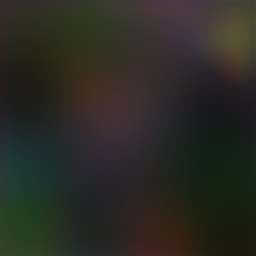

In [ ]:
Image(filename='/content/saved_examples/epoch0/img_99.png')

In [74]:
generate_examples(gen, 270)